# Static traffic assignment iPython code
*** 
- [Section 1](#graph) upload the graph
- [Section 2](#demand) upload the demand
- [Section 3](#assignment) encode the all or nothing function
- TO DO

***
We want to solve the following problem (TAP):
\begin{align}
\min_{\textbf{h}} &\sum_{a} \int_{0}^{f_a} t_a(s)\; \text{d}s
\\
\text{s.t.  } & \;\; \textbf{f} = \Delta \textbf{h}
\\
& \;\; 
\textbf{h} \geq 0
\\
& \;\; 
A \textbf{h} = \textbf{d}
\end{align}

The static traffic assigment problem (STA) states the Wardrop conditions as the equivalent optimization problem above. 

The Wardrop conditions are as follows [[Patriksson](#references)]:
- Wardrop's first principle: all journey times are equal, and is less than the time experienced by a single vehicle on any other unused route.
- Wardrop's second principle: the average journey time is a minimum.

Notation:
- For $\left( p,q \right) \in C$ (an origin-destination pair) and route $r \in R_{pq}$ (the set of simple routes from $p$ to $q$), $c_{pqr}$ is the travel time.
- $h_{pqr}$ is the flow on the $r$ from $p$ to $q$.
- $\pi_{pq}$ is the shortest travel time from $p$ to $q$.
- $d_{pq}$ is the demand for the OD pair $(p,q)$.

The Wardrop User equilibrium conditions occurs if and only if the following is true for $l$ routes on $(p,q)$:

$$ c_{pq1} = ... = c_{pql} $$

This condition can be equilavently stated as

$$ h_{pqr} > 0 \implies c_{pqr} = \pi_{pq}, \forall r \in R_{pq} $$
$$ h_{pqr} = 0 \implies c_{pqr} \geq \pi_{pq}, \forall r \in R_{pq} $$

, which holds for all $(p,q) \in C$. The idea is that for all routes with flow, the travel time is optimal, and that for all paths with not flow the travel time is greater then or equal to optimal. This condition can be restated as the following alongside certain feasibility conditions:

$$ h_{pqr}(c_{pqr} - \pi_{pq}) = 0, \ \forall r \in R_{pq}, \ \forall (p,q) \in C $$

$$ c_{pqr} - \pi_{pq} \geq 0, \ \forall r \in R_{pq}, \ \forall (p,q) \in C $$

$$ \sum_{r \in R_{pq}} h_{pqr} = d_{pq}, \ \forall (p,q) \in C $$

$$ h_{pqr} \geq 0, \ \forall r \in R_{pq}, \ \forall (p,q) \in C $$

$$ \pi_{pq} \geq 0, \ \forall (p,q) \in C $$

TO DO: TRY TO HAVE A PROOF WHICH IS NOT IN THE PATRIKSSON BOOK: FROM THE 4 EQUATIONS ABOVE TO THE VARIATIONAL INEQUALITY: $c(h^\star)^\top(h-h^\star) \geq 0$.

Theorem 2.1 [[Patriksson](#references)] states that the Wardrop conditions are equivalent to the first order condition of the TAP problem listed above. The intuition behind the idea follows from taking the Lagrangian of the optimization problem using multipliers $\boldsymbol{\lambda}$ from the third constraint:

$$ L(\textbf{h},\boldsymbol{\lambda}) = T(\textbf{f}(\textbf{h})) + \sum_{(p,q) \in C} \lambda_{pq}(d_{pq} - \sum_{r \in R_{pq}} h_{pqr}) $$

The remaining proof uses the stationary of the Lagrangian and fact that the partial derivative of $T$ with respect to the flow along a certain route ($h_{pqr}$) is the travel time $c_{pqr}$ to rederive the Wardrop conditions. We can also interpret the multiplier $\boldsymbol{\lambda}$ as the minimum route cost between $p$ and $q$, so $\boldsymbol{\lambda}$ is $\boldsymbol{\pi}$.

## 0. Import some libraries useful for the project
***

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import scipy
import matplotlib.pyplot as plt
#%run -i 'network.py'

In [2]:
#test
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt

def read_metadata(file):
    """
    Parameter: 
        file: a string which represent the path to the data file tntp.
    Return:
        The function read the first metadata lines (in the <> tag) and return the numbers of lines read.
    """
    inputfile = open(file)
    line = inputfile.readline()
    line_skip = 0
    # parsing metadata
    while "<" in line:
        line_skip += 1
        # print(line, end="")
        line = inputfile.readline()
    """   
    # skip all the blank line
    while len(line)<2:
        line_skip += 1
        line = inputfile.readline()
    """ 
    return line_skip
    # print(line)
    # return line, line_skip

def read_data(file, line_skip):
    """
    Parameter: 
        file: a string which represent the path to the data file tntp
        line_skip: the number of lines of metadata to skip (should be the output of read_metadata(file))
    Return:
        The function read the tntp file using pandas.
        It drops the columns ~ and ;
        Then it return the legend and the data in a np.array
    """
    table = pd.read_csv(file, sep='\t', header=line_skip)
    
    # remove columns with ~ or ;
    to_remove = set({})
    for i in range(table.columns.shape[0]):
        if '~' in table.columns[i] or ';' in table.columns[i]:
            # print(i)
            to_remove.add(i)
    table = table.drop(table.columns[list(to_remove)], axis=1)
    
    # HERE we should do some data type change (init node, term node and power should be 32 bit integer)
    legend = np.array(table.columns)
    table_tmp = np.array(table)
    del table
    # get the legend and the data with np
    return legend, table_tmp

def init_travel_time_function(network):
    """
    Parameter: 
        network: a string which represent the path to the data file tntp
    Return:
        The table that can be used to compute the travel time of every links.
        The index of the free flow travel time, of the B, of the capacity and of the power columns.
        
        The travel time of a link (one row of the table) is t(f) = t0 * (1 + B*(f/capacity)**power)
    """
    file_type = "net"
    suffix = "_" + file_type + ".tntp"
    line_skip = read_metadata(network + suffix)
    legend_net, table_net = read_data(network + suffix, line_skip)
    
    j = 0
    for legend_name in legend_net:
        # print(legend_name)
        if "B" in legend_name:
            index_B = j
        if "Power" in legend_name:
            index_power = j
        if "Free Flow Time" in legend_name:
            index_fft = j
        if "Capacity" in legend_name:
            index_capacity = j
        if ("Init" in legend_name) or ("Tail" in legend_name):
            index_init = j
        if ("Term" in legend_name) or ("Head" in legend_name):
            index_term = j
        j += 1
    graph_wrapped = table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term
    return graph_wrapped

def flow_cost_solution(network):
    """
    Read and return the flow and the cost of the STA solution using the flow.tntp file
    """
    file_type = "flow"
    suffix = "_" + file_type + ".tntp"
    line_skip = read_metadata(network + suffix)
    legend_flow, table_flow = read_data(network + suffix, line_skip)
    j = 0
    for legend_name in legend_flow:
        if "Volume" in legend_name:
            index_flow = j
        if "Cost" in legend_name:
            index_cost = j
        j += 1

    flow = table_flow[:,index_flow]
    cost_solution = table_flow[:,index_cost]
    return flow, cost_solution

def read_demand(network):
    """
    Parameter: 
        file: a file name that encode the demand under a TNTP format (network_trips.tntp).
    Return:
        A dictionary of keys based sparse matrix encoding the demand.
    """
    file_type = "trips"
    file = network + "_" + file_type + ".tntp"
    inputfile = open(file)
    line = inputfile.readline()
    # parsing metadata
    while "<" in line:
        print(line, end="")
        line = inputfile.readline()

    # skip all the blank line
    while len(line)<2:
        line = inputfile.readline()

    # read the Origin
    assert 'Origin' in line
    data = {}
    # print(line, end="")
    origin = None
    try:
        origin = int(line.split('\t')[1])
    except:
        origin = int(line.split(' ')[1])
    data[origin] = {}
    for line in inputfile:
        # print(line, end="")
        if 'Origin ' in line:
            origin = None
            try:
                origin = int(line.split('\t')[1])
            except:
                origin = int(line.split(' ')[1])
            data[origin] = {}
        # else read the destination
        else:
            dest_array = line.split(";")
            for dest in dest_array[:-1]:
                dest_tmp = dest.split(":")
                data[origin][int(dest_tmp[0])] = float(dest_tmp[1])

    d = pd.DataFrame(data)
    del data

    demand = sparse.csr_matrix(np.array(d))
    del d
    # print(demand)
    return demand.todok()

def get_graph(graph_wrapped):
    """
    Parameter:
        graph_wrapped: should be = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term)
    Return:
        A dictionary encoding the graph: graph[origin][destination] = link_id
    """
    table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term = graph_wrapped
    
    graph = {}
    for i in range(table_net.shape[0]):
        link_index = i
        node_init = int(table_net[i][index_init])
        node_term = int(table_net[i][index_term])
        
        if node_init not in graph:
            graph[node_init] = {}
        # if node_term not in graph[node_init]:
        #     graph[node_init][node_term] = {}
        # we assume that there is only one possible directed link between two nodes
        graph[node_init][node_term] = link_index
    return graph

def neighbours(node, adj):
    """
    Parameter:
        node: node for which to find neigbours for
        adj: adjacency matrix that describes network
    Return:
        List of nodes that are neighbours to node
    """
    return np.nonzero(adj[node])[0].tolist()

def add_flow_dijkstra(adj, src, target, faon, flow, g):
    """
    Parameter:
        adj: adjacency matrix that describes network
        src: starting node for OD pair
        target: end node for OD pair
        faon: current all or nothing flow allocation that the algorithm is building
        flow: demand of the current of OD pair
        g: graph dictionary, g[node_init] = {node_term_1: link_from_init_to_term_1, node_term_2: link_from_init_to_term_2}
    Return:
        Returns all or nothing flow allocation, where flow is allocated by shortest path for OD pair (as determined by Dijkstra's algorithm)
    """
    q = [i for i in range(len(adj))] # queue of nodes
    dist = [np.inf for i in range(len(adj))] # node distances
    prev = [None for i in range(len(adj))] # predecessor in shortest path
    
    dist[src] = 0 # set source node's distance to itself as zero
    
    while len(q) != 0:
        u = min(q, key=lambda n:dist[n])
        q.remove(u)
        
        if u == target: # when target is reach, use predecessors to allocate all or nothing flow to links in shortest path
            while u != src:
                prev_node = prev[u]
                curr_link = g[prev_node+1][u+1]
                faon[curr_link] += flow
                u = prev_node
            return faon
        
        for v in neighbours(u, adj):
            alt = dist[u] + adj[u][v]
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u

## 1. Import the road network and its characteristics <a id="graph"></a>
***
The road network is composed by:
- $G=(E,V)$ a **strongly connected oriented graph** with vertices $v\in V$ and edges $e\in E$
- $t_{0,e}\in\mathbb{R}_+$ the **free flow travel time** of the edge $e$, $\forall e\in E$
- $c_{e}\in\mathbb{R}_+$ the **flow capacity** of the edge $e$, $\forall e\in E$
- $B_e\in\mathbb{R}_+$ and $p_e\in\mathbb{N}_+$ two characteristics of the edge $e$ useful for estimating the travel time of vehicle on the edge $e$ given the flow of the edge $e$, $\forall e\in E$

Data are provided from https://github.com/bstabler/TransportationNetworks.
They are is the folder `data/`.

The road network and its characteristics are read in the file `network.py` with the function:
- `init_travel_time_function(network) : graph_wrapped`: takes as parameter a string which represent the path to the data file TNTP `network` and return in `graph_wrapped` the table that can be used to compute the travel time of every links, and the index of the free flow travel time, of the B, of the capacity and of the power columns.
_TO DO: Better explain this_

In [3]:
#from network import init_travel_time_function

## 2. Import the road demand <a id="demand"></a>
***
The road demand is a matrix $r \in \mathbb{R}_+^{|V| \times |V|}$ where:
- $r_{o,d}$ is the demand between the origin $o\in V$ and the destination $d\in V$.

Remark that for most of the vertices $u,v\in V$, $r_{u,v}=0$ so the demand matrix is very sparse.

The road demand are read in the file `network.py` with the function:
- `read_demand(file): demand`: takes as parameter a string which represent the path to the data file TNTP `network` and return in `demand` a dictionary of keys based sparse matrix representing the demand $r$.

In [4]:
#from network import read_demand

## 3. Define the link travel time as a function of the link flow <a id="travel_time"></a>
***
The travel time of every link $e\in E$ is given as a function of the flow on the link $f_e\in\mathbb{R}_+$ and of [the characteristics of the edge](#graph):
$$ t_e(f_e) = t_{0,e} \cdot \left( 1 + B_e \cdot \left(\frac{f_e}{c_e}\right)^{p_e} \right) $$
This is the classical BPR function as defined in [[Patriksson](#references)]. 

The function `travel_time(flow, graph_wrapped): travel_time` computes it: it gives the travel time vector for every link given the [graph_wrapped](#graph) and the vector of link flow.

A test is provided at the [end of the notebook](#tests).

In [5]:
def travel_time(flow, graph_wrapped):
    """
    Parameter: 
        flow: a vector that represents the flow of every links
        graph_wrapped: should be = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term)
    Return:
        A travel time vector for every links given the flow allocation flow.
        
        The travel time of a link (one row of the table) is t(f) = t0 * (1 + B*(f/capacity)**power)
    """
    table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term = graph_wrapped
    return table_net[:,index_fft] * (1 + table_net[:,index_B]*(flow/table_net[:,index_capacity])**table_net[:,index_power])

## 4. Import an encoding of the graph<a id="demand"></a>
***
The graph encoding is a matrix $r \in \mathbb{R}_+^{|V| \times |V|}$ where:
- $r_{o,d}$ is the ID of the link between the origin $o\in V$ and the destination $d\in V$.

The encoding of the graph is read in the file `network.py` with the function:
- `get_graph(graph_wrapped): graph`: takes as parameter a list the characterization of edges in the network and returns a dictionary that encodes link ID by origin-destination pairs.

In [6]:
#from network import get_graph

## 5. Initialize Network <a id="assignment"></a>
***
Initialize the network by running the previously defined functions to generate the necessary data needed.

- `initialization(network) : graph_wrapped, demand, graph, nb_links`: TO DO

In [7]:
def initialization(network):
    """
    Parameter:
        network: the file name of the data 
    Return:
        graph_wrapped, demand, graph, nb_links using previously defined functions
    """
    graph_wrapped = init_travel_time_function(network)
    demand = read_demand(network)
    graph = get_graph(graph_wrapped)

    table_net, _, _, _, _, _, _ = graph_wrapped
    nb_links = table_net.shape[0]
    return graph_wrapped, demand, graph, nb_links

# we have the demand in the sparse matrix demand, and the travel_time function in travel_time
# we have the graph of the network in graph


## 6. Assignment <a id="assignment"></a>
***
TO BE CHANGED AND COMMENTED AS ABOVE.
- PUT get_graph IN network.py. THEN IMPORT IT AND EXPLAIN WHY WE NEED IT. DONE
- EXPLAIN initialization


Descent Algorithm: Frank-Wolfe

The following linearly constrained optimization problem

$$ \min_{x} f(x) $$

$$ \text{s.t} \ Ax = b, x \geq 0 $$

can be transformed by the Frank Wolfe algorithm into the following:

$$ \min_{y} \nabla f(x^k)^Ty $$

$$ \text{s.t} \ Ay = b, y \geq 0 $$

The algorithm tries to solve the problem iteratively, where on the kth iteration it uses a feasible solution $x^k$ to find the search direction $y$. The intuition for this comes from finding the solution of the first order approximation of the objective function rather than the solution to the objective itself:

$$ \min_{y} f(x^k) + \nabla f(x^k)^T(y-x^k) $$

Since we only care about finding the optimal $y$ for the problem we can ignore constants, so the problem is equivalent to

$$ \min_{y} \nabla f(x^k)^Ty $$

Once we've found this $y$, we do a line search in the direction $d = y - x^k$ to find the step size $\alpha_k$:

$$ \min_{0 \leq \alpha_k \leq 1} f(x^k + \alpha_{k}d) $$

***

In the case of the traffic assignment problem, the solution to the iterative optimization step $y$ is the all or nothing allocation of flow (named as all flow is placed all on a certain path and not others). This comes from the fact that as we are optimizing over linear constraints the solution is at a single vertex on the polytope that represents the feasible space, which represents the allocation of flow based on the shortest paths in solution (which is found using Dijkstra's Algorithm).

As with Frank Wolfe's algorithm, we undertaking line search using the potential function and use the bisection method to find the ideal step size. The bisection method is approximate as it relies on a resolution $r$ (at which higher values it is more accurate), though it has complexity $O(log \ r)$ so it is computationally efficient. Generally, the sequence $f(x^k)$ is monotonically decreasing for Frank Wolfe, though due to this approximation this is not always the case in our implementation. Exceptions to this loop invariance problem are recorded.

TO DO: REMOVE THE COMPUTATION OF THE ADJACENCY MATRIX AND USE THE GRAPH DICTIONARY AND `tt` (TRAVEL TIME VECTOR)

In [8]:
import scipy
from scipy.sparse.csgraph import dijkstra

def update_travel_time_from_tt(graph, tt):
    nb_nodes = len(graph)
    G = np.zeros(shape=(nb_nodes,nb_nodes))
    G = scipy.sparse.lil_matrix(G)
    for i in graph.keys():
        for j in graph[i].keys():
            G[i-1, j-1] = tt[graph[i][j]] # THIS IS VERY BAD BECAUSE I PUT i-1 and j-1 instead of i and j
    G = G.tocsr()
    return G

# def put_on_shortest_path(faon, o_tmp, d_tmp, flow_tmp, tt, g, G):
#     """
#     Parameter:
#         faon: current all or nothing flow allocation that the algorithm is building
#         o_tmp: origin of the current od pair
#         d_tmp: destination of the current od pair
#         flow_tmp: demand of the current of pair
#         tt: travel time on every links, tt[l] = travel time of the link l
#         g: graph dictionary, g[node_init] = {node_term_1: link_from_init_to_term_1, node_term_2: link_from_init_to_term_2}
#     Return:
#         TO WRITE
#     """
#     dist_matrix, return_predecessors = dijkstra(G, return_predecessors = True) # change
    
#     node_tmp = d_tmp
#     # using the dijkstra, we build the fastest path and we put the flow on it.
#     while node_tmp != o_tmp:
#         node_tmp_d = return_predecessors[o_tmp][node_tmp]
#         # Here we need the graph_dict to recover the link id from the nodes id.
#         link_tmp = g[node_tmp_d+1][node_tmp+1] # this is very bad because we use node_tmp +1 and node_tmp_d + 1 instead of node_tmp and node_tmp_d
#         faon[link_tmp] += flow_tmp
#         node_tmp = node_tmp_d

#     return faon

# all or nothing function
def all_or_nothing(d, tt, g):
    """
    Parameter:
        d: a demand as sparse matrix, d[origin][dest] = demand between origin and dest
        tt: travel time on every links, tt[l] = travel time of the link l
        g: graph dictionary, g[node_init] = {node_term_1: link_from_init_to_term_1, node_term_2: link_from_init_to_term_2}
    Return:
        The all or nothing flow allocation corresponding to the demand d and the travel time tt.
    """
    nb_links = tt.shape
    faon = np.zeros(nb_links)
    
    G = update_travel_time_from_tt(g, tt) # to remove for putting the dijkstra algorithm
    adj = G.toarray()
    
    for o_tmp, d_tmp in d.keys():
        #sp = find_sp(o_tmp, d_tmp)
        #faon = add_flow(faon, sp, d[o_tmp, d_tmp])
        faon = add_flow_dijkstra(adj, o_tmp, d_tmp, faon, d[o_tmp, d_tmp], g) # TO DO: Pass g and tt instead of adj
        # flow_tmp = d[o_tmp, d_tmp]
        # faon = put_on_shortest_path(faon, o_tmp, d_tmp, flow_tmp, tt, g, G) # to change when we write our own 
    return faon

#def find_sp(g):

def potential(f, graph_wrapped):
    """
    Parameter:
        flow: a vector that represents the flow of every links
        graph_wrapped: should be = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term)
    Return:
        The potential function tha t we want to minimize.
        
        The potential function is (one row of the table) is sum(int(t_e(s), s in [0, f_e]), e) = sum(t0 * (f + B*(f/capacity)**(power+1)/power)).    
        This function is useful for doing a line search, it computes the potential at flow assignment f.
    """
    table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term = graph_wrapped
    pot_tmp = table_net[:,index_fft] * f * (1 + (table_net[:,index_B] / table_net[:,index_power])*(f/table_net[:,index_capacity])**table_net[:,index_power])
    return np.sum(pot_tmp)

def line_search(f, res=20):
    """
    Parameter:
        f: the function that we want to minimize between 0 and 1
        res: the resolution of the grid ([0, 1] is divided in 2^res points).
    Return:
        On a grid of 2^res points bw 0 and 1, find global minimum for a continuous convex function using bisection 
    """
    d = 1. / (2**res - 1) # d: Size of interval between adjacent points
    l, r = 0, 2**res - 1 # l: first point, r: last point
    while r - l > 1:
        if f(l * d) <= f(l * d + d): # Interval l: [l*d, l*d + d]
            return l * d
        if f(r * d - d) >= f(r * d):
            return r * d
        # otherwise f(l) > f(l+d) and f(r-d) < f(r)
        m1, m2 = (l + r) / 2, 1 + (l + r) / 2
        if f(m1 * d) < f(m2 * d):
            r = m1
        if f(m1 * d) > f(m2 * d):
            l = m2
        if f(m1 * d) == f(m2 * d):
            return m1 * d
    return l * d

# write pseudocode STA
epsilon = 0.01

# initialization
network = 'data/SiouxFalls/SiouxFalls'
graph_wrapped, demand, graph, nb_links = initialization(network)

table_net, _, _, _, _, _, _ = graph_wrapped
nb_links = table_net.shape[0]


f = all_or_nothing(demand, travel_time(np.zeros(nb_links), graph_wrapped), graph)
f_iter = []
tt_iter = []
incr_tt = []
alpha = 1
i = 0
while alpha>epsilon and i<1000:
    f_iter.append(f)
    tt = travel_time(f, graph_wrapped)
    faon = all_or_nothing(demand, tt, graph)
    tt_iter.append(np.dot(tt,(f - faon)))
    alpha = line_search(lambda a : potential((1. - a) * f + a * faon, graph_wrapped))
    f = (1-alpha) * f + alpha * faon
    # loop invariant
    if i != 0 and tt_iter[i] > tt_iter[i-1]:
        incr_tt.append(i)
    i = i+1
    
if len(incr_tt) > 0:
    print("Exceptions to loop variance occured in the following iterations: \n")
    print(str(incr_tt))
print("Iterations: ", i)
#print(f)
flow, cost = flow_cost_solution(network)
print(flow)
print(potential(flow, graph_wrapped))
print(potential(f, graph_wrapped))
print(np.linalg.norm(f-flow)/np.linalg.norm(flow))

<NUMBER OF ZONES> 24
<TOTAL OD FLOW> 360600.0
<END OF METADATA>
Exceptions to loop variance occured in the following iterations: 

[4, 10, 21, 24, 26, 28, 30, 33, 35, 36, 41, 43, 46, 50, 52, 53, 56, 57, 58, 63, 67]
Iterations:  68
[ 4494.65764646  8119.07994805  4519.07994805  5967.33639617
  8094.65764646 14006.37101986 10022.31961516 14030.5609174
 18006.37101986  5200.         18030.5609174   8798.26771411
 15780.78205547  5991.75869776  8806.49866681 12492.92536056
 12101.52912231 15794.01060698 12525.57861486 12040.91827285
  6882.66491266  8388.713063   15796.7410003   6836.70597529
 21744.07608018 21814.07608764 17726.62503296 23125.7972901
 11047.09388127  8100.          5300.         17604.22353323
  8365.28565386  9776.11953275  9973.70741603  8404.93462395
 12287.60526902 12378.64203998 11121.35796002  9814.06906293
  9036.33413403  8400.43683027 23192.28335936  9079.82031659
 19083.28976475 18409.93502652  8406.71440521 11073.00931921
 11695.00291653 15278.32524152  8100.  

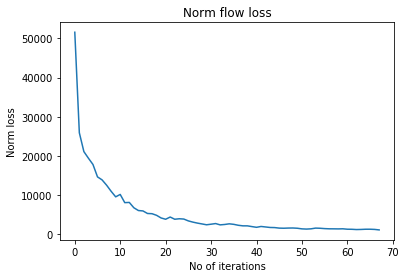

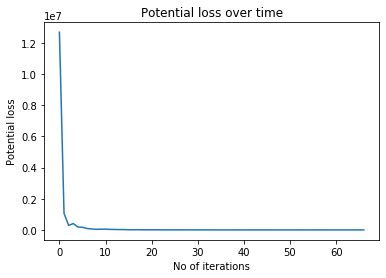

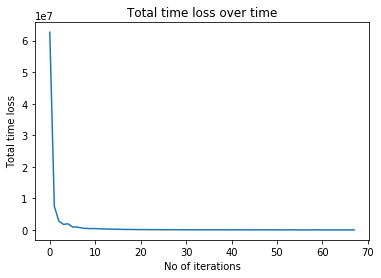

In [9]:
norm_flow_loss = [np.linalg.norm(f-flow,2) for f in f_iter]
plt.figure()
plt.title("Norm flow loss")
plt.ylabel("Norm loss")
plt.xlabel("No of iterations")
plt.plot(norm_flow_loss)
plt.show()

potential_loss = [potential(f_iter[i], graph_wrapped)-potential(f_iter[i+1], graph_wrapped) for i in range(len(f_iter)-1)]
plt.figure()
plt.title("Potential loss over time")
plt.ylabel("Potential loss")
plt.xlabel("No of iterations")
plt.plot(potential_loss)
plt.show()

plt.figure()
plt.title("Total time loss over time")
plt.ylabel("Total time loss")
plt.xlabel("No of iterations")
plt.plot(tt_iter)
plt.show()

## 6. Fukushima: A Modified Frank Wolfe Algorithm <a id="assignment"></a>
***
Fukushima explanation

In [29]:
# write pseudocode STA
epsilon = 0.01

# initialization
network = 'data/SiouxFalls/SiouxFalls'
graph_wrapped, demand, graph, nb_links = initialization(network)

table_net, _, _, _, _, _, _ = graph_wrapped
nb_links = table_net.shape[0]

f = all_or_nothing(demand, travel_time(np.zeros(nb_links), graph_wrapped), graph)
f_iter = []
tt_iter = []

f_iter.append(f)

faons = []

alpha = 1.0
k = 1
l = 2
incr_tt = []

while alpha>epsilon and k<1000:
    x_k = f_iter[-1]
    tt = travel_time(x_k, graph_wrapped)
    faon = all_or_nothing(demand, tt, graph) # y_k
    faons.append(faon)
    y_k = faon
    if np.dot(tt,(y_k - x_k)) == 0: # you can try as < epsilon
        print("Break")
        break
    
    q = min(k, l) - 1

    lamb = 1/(q+1)
    v_k = np.add.reduce([lamb*(faons[-(q+1):][i]) for i in range(q+1)]) - x_k
    w_k = y_k - x_k
    
    gamma1_k = np.dot(v_k/np.linalg.norm(v_k), tt)
    gamma2_k = np.dot(w_k/np.linalg.norm(w_k), tt)
    
#     print(np.add.reduce([lamb*(faons[-(q+1):][i]) for i in range(q+1)]))
#     print([lamb*(faons[-(q+1):][i]) for i in range(q+1)])
#     print(gamma1_k, gamma2_k)
#     break
    
    if gamma1_k < gamma2_k:
        d_k = v_k
        print("a", end=", ")
    elif gamma1_k == gamma2_k:
        r = np.random.random()
        u_k = (r*v_k+(1-r)*w_k)
        d_k = u_k
        print("b", end=", ")
    else:
        d_k = w_k
        print("c", end=", ")
    alpha = line_search(lambda a : potential(x_k + a * d_k, graph_wrapped))
    f_iter.append(x_k + alpha*d_k)
    k = k + 1
    tt_iter.append(np.dot(tt,(f_iter[-1] - faon)))
    
print("\nIterations: ", str(k-1))
print("Alpha: ", alpha)
flow, cost = flow_cost_solution(network)
print(potential(flow, graph_wrapped))
print(potential(f_iter[k-1], graph_wrapped))
print(np.linalg.norm(f_iter[-1]-flow)/np.linalg.norm(flow))

<NUMBER OF ZONES> 24
<TOTAL OD FLOW> 360600.0
<END OF METADATA>
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b
b

Iterations:  68
Alpha:  0.007909197130533622
4434390.915720795
4444951.255770635
0.009339324311215438


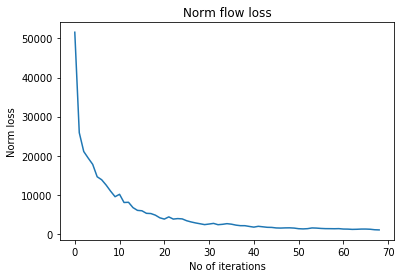

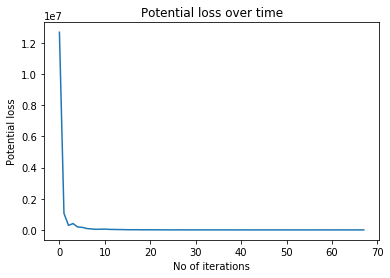

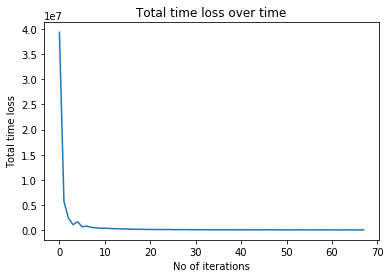

In [16]:
norm_flow_loss = [np.linalg.norm(f-flow,2) for f in f_iter]
plt.figure()
plt.title("Norm flow loss")
plt.ylabel("Norm loss")
plt.xlabel("No of iterations")
plt.plot(norm_flow_loss)
plt.show()

potential_loss = [potential(f_iter[i], graph_wrapped)-potential(f_iter[i+1], graph_wrapped) for i in range(len(f_iter)-1)]
plt.figure()
plt.title("Potential loss over time")
plt.ylabel("Potential loss")
plt.xlabel("No of iterations")
plt.plot(potential_loss)
plt.show()

plt.figure()
plt.title("Total time loss over time")
plt.ylabel("Total time loss")
plt.xlabel("No of iterations")
plt.plot(tt_iter)
plt.show()

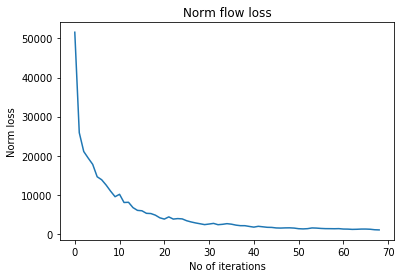

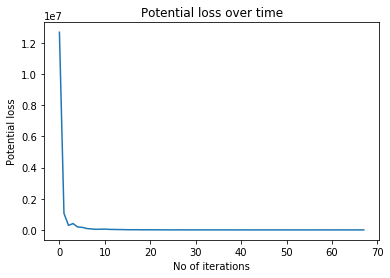

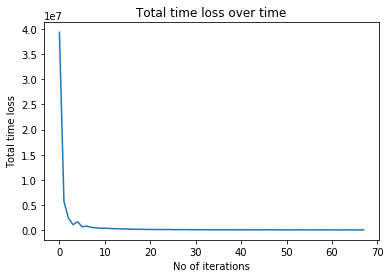

In [17]:
norm_flow_loss = [np.linalg.norm(f-flow,2) for f in f_iter]
plt.figure()
plt.title("Norm flow loss")
plt.ylabel("Norm loss")
plt.xlabel("No of iterations")
plt.plot(norm_flow_loss)
plt.show()

potential_loss = [potential(f_iter[i], graph_wrapped)-potential(f_iter[i+1], graph_wrapped) for i in range(len(f_iter)-1)]
plt.figure()
plt.title("Potential loss over time")
plt.ylabel("Potential loss")
plt.xlabel("No of iterations")
plt.plot(potential_loss)
plt.show()

plt.figure()
plt.title("Total time loss over time")
plt.ylabel("Total time loss")
plt.xlabel("No of iterations")
plt.plot(tt_iter)
plt.show()

## 10.Tests <a id="tests"></a>
***
Here are a bunch of tests to verify that our code is correct.

### 10.1 Test of the [travel time function](#travel_time)
- `flow_cost_solution(network) : optimal_flow, cost_solution`: takes as parameter a string which represent the path to the data file tntp `network` and return the flow and the cost of the STA solution by reading it in the data provided.
- `test_travel_time_function(network, graph)` tests if travel_time gives the correct cost when the optimal flow allocation is given in the data (like in __data/SiouxFalls/SiouxFalls__)

In [9]:
from network import flow_cost_solution

def test_travel_time_function(network, graph):
    """
    Parameter:
        file: a string which represent the path to the data file tntp
    Using the flow.tntp file (solutions) and the travel time function,
    the function tests if travel_time(flow_solutions) == cost_solutions
    Return:
        A vector of the differences between travel_time(flow_solutions) and cost_solutions for every links
    """
    flow, cost_solution = flow_cost_solution(network)
    print(np.linalg.norm(travel_time(flow, graph) - cost_solution))
    return travel_time(flow, graph) - cost_solution

# test if our travel_time function is correct
# network = 'data/SiouxFalls/SiouxFalls'
# network = 'data/Eastern-Massachusetts/EMA'
# network = 'data/Berlin-Tiergarten/berlin-tiergarten'
for network in {'data/SiouxFalls/SiouxFalls', 'data/Anaheim/Anaheim'}:
    graph_wrapped = init_travel_time_function(network)
    test_travel_time_function(network, graph_wrapped)
print()

3.277847697668423e-14
3.807809309113039e-15



## References <a id="references"></a>
***
- [Patriksson] The Traffic Assignment Problem - Models and Methods, M.Patriksson